# Tutorial 4: Statistical inference on representational geometries

## In this tutorial you'll learn about:
- Representational Similarity Analysis (RSA)
- How to get activations from different layers of an artificial neural network
- Frequentist model comparison methods
- Three sources of estimation error in statistical inference: measurement noise, stimulus sampling, subject sampling, and how they motivate model-comparative frequentist inference using the 2-factor bootstrap

## Plan
1. Load fMRI data (V1 and FFA) for a set of images
2. Get artificial neural network activations for the same images
3. Create representational dissimilarity matrices (RDMs)
4. Representational similarity analysis (RSA) comparing model and neural data RDMs
5. Model comparison using 2-factor bootstrap

first let's make some imports

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np  ## numpy for array-based operations
np.random.seed(0) # numpy random seed

import torch        ## the pytorch deep learning library
import torchvision  ## the torchvision package provides us with an easy way to download a pre-trained model
from PIL import Image ## we can use the Image class to read in the stimuli

from pathlib import Path ## the Path class makes navigating directories easier
import rsatoolbox as rsa ## library for representational similarity analysis

import matplotlib.pyplot as plt ## the matplotlib plotting library
## here we include a module with some functions for custom visualizations in this notebook:
import interactive_plotting as intplot

In [2]:
# some constants
SUBJECTS = list(range(1, 9)) # there are 8 subjects
ROIS = ["V1", "FFA"] # regions of interest in fmri data
IMAGES_DIR = Path('images') 
FMRI_PATTERNS_DIR = Path('fmri_patterns')

## 1. Load fMRI data (V1 and FFA)

![](https://naturalscenesdataset.org/nsdcoffeemugSMALL.jpg)

We take fMRI response patterns are from the [Natural Scene Dataset](https://naturalscenesdataset.org/). 
NSD is a large 7T fMRI dataset of 8 adults viewing more than 73 thousand photos of natural scenes.

We have taken a small subset of 90 images from NSD and have pre-extracted the fRMI data for V1 and Fusiform Face Area (FFA) from 8 subjects.

### Loading the images

First, let's load the 90 image files with the Pillow Image class.

In [3]:
image_paths = sorted(IMAGES_DIR.glob("*.png")) ## find all pngs file paths in the image directory
images = [Image.open(p).convert('RGB') for p in image_paths] ## Load them as Image objects
np.array(images[0]).shape ## dimensions of the image array: width x height x channels (RGB)

(425, 425, 3)

Now let's take a look at these images.
Notice that the first 45 images we selected have no faces, while the other 45 do have a face in them!
So we should expect to see a 2x2 block pattern in the Fusiform Face Area (FFA) representational dissimilarity matrices (RDMs).

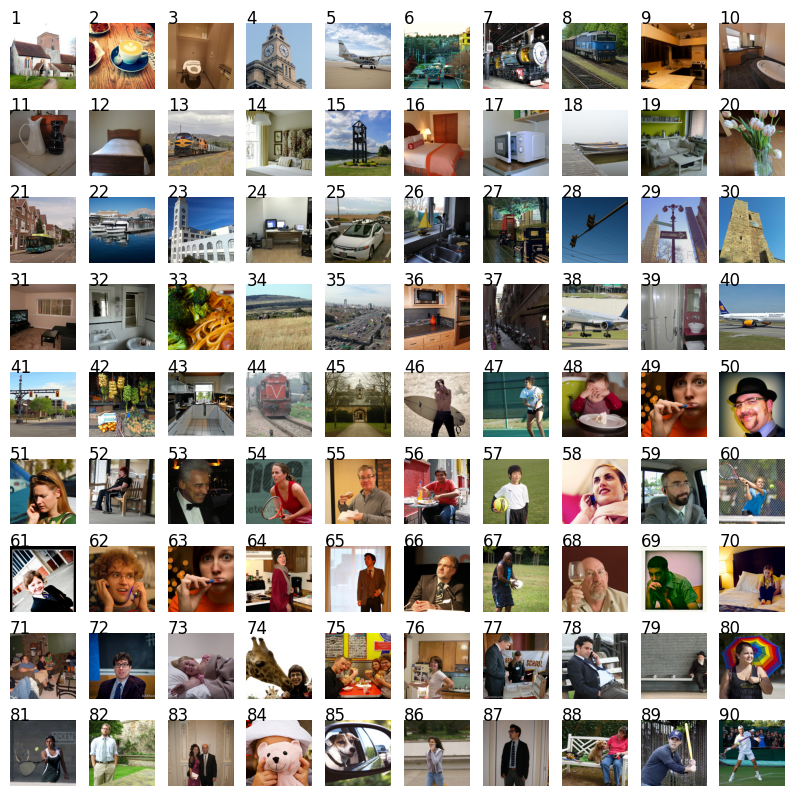

In [4]:
fig, ax = plt.subplots(9, 10, figsize=(10, 10))

for i, img in enumerate(images):
    ax[i//10, i%10].imshow(img)
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].text(0, 0, str(i+1), color='black', fontsize=12)
plt.show()

### Loading fMRI patterns from the NSD datset

Let's now load the fMRI patterns from the NSD dataset for these 90 images.
We have pre-extracted the patterns, so we just need to load numpy arrays from ".npy" files.

Note that we have 8 subjects and our regions of interest (ROIs) are V1 and FFA.

In [5]:
# loading fmri data
fmri_patterns = {}
for subject in SUBJECTS:
    fmri_patterns[subject] = {}

    for roi in ROIS:
        fmri_patterns[subject][roi] = {}

        full_data = np.load(FMRI_PATTERNS_DIR / f"subj{subject}_{roi}.npy")
        fmri_patterns[subject][roi] = full_data

# this is how we can index into subject 5 FFA patterns for all the images
fmri_patterns[5]["V1"].shape # number of images x number of voxels

(90, 2950)

## 2. Get artificial neural network activations

Now that we have fMRI patterns, we want to explain this data using computational models.

In this tutorial, we will take our models to be **layers of AlexNet**.

![](https://d2l.ai/_images/alexnet.svg)

*Comparing LeNet architecture to AlexNet. Image from [Dive Into Deep Learning book](https://d2l.ai/).*

AlexNet is a famous convolutional neural network that won the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) challenge in 2012 and started the "deep learning revolution".

We load a version of AlexNet that is already pre-trained on ImageNet.
This step may take a minute, feel free to read ahead.

In [6]:
# Load AlexNet model pretrained on ImageNet
alexnet = torchvision.models.alexnet(weights="IMAGENET1K_V1")

To pass images through the model, we need to _preprocess_ them to be in the same format as the images passed shown to the model during training.

With AlexNet this includes resizing the images to 224x224 and normalizing their color channels to particular values. We also need to turn them into PyTorch tensors.

In [7]:
# preprocess NSD images as input to alexnet
# (we need to use the exact same preprocessing as was used to train AlexNet)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)), # resize the images to 224x24 pixels
    torchvision.transforms.ToTensor(), # convert the images to a PyTorch tensor
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the image color channels
])

images_tensor = torch.stack([transform(img) for img in images])
print(images_tensor.shape) # (number of images, channels, height, width)

torch.Size([90, 3, 224, 224])


Let's inspect AlexNet architecture to select some of the layers as our "models":

In [8]:
from torchvision.models.feature_extraction import get_graph_node_names

print("Architecture of AlexNet:")
print(alexnet)

node_names = get_graph_node_names(alexnet) # this returns a tuple with layer names for the forward pass and the backward pass
print("\nGraph node names (layers) in the forward pass:")
print(node_names[0]) # forward pass layer names

Architecture of AlexNet:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_fe

We extract activations from different layers of AlexNet looking at the same images that we got our NSD fMRI patterns from:

In [9]:
from torchvision.models.feature_extraction import create_feature_extractor

# make hooks in alexnet to extract activations from different layers
return_nodes = {
    "features.2": "conv1",
    "features.5": "conv2",
    "features.7": "conv3",
    "features.9": "conv4",
    "features.12": "conv5",
    "classifier.1": "fc6",
    "classifier.4": "fc7",
    "classifier.6": "fc8"
}
feature_extractor = create_feature_extractor(alexnet, return_nodes=return_nodes)

In [10]:
# extract activations from alexnet
alexnet_activations = feature_extractor(images_tensor)

# convert to numpy arrays
for layer, activations in alexnet_activations.items():

    act = activations.detach().numpy().reshape(len(images), -1)
    alexnet_activations[layer] = act  # Keep original data under 'all'

alexnet_activations['conv1'].shape # number of images x number of neurons in conv1 layer

(90, 46656)

# 3. Create representational dissimilarity matrices (RDMs)

Now that we have fMRI patterns and AlexNet activations, the first step in representation similarity analysis (RSA) is to compute the representational dissimilarity matrices (RDMs). RSA characterizes the representational geometry of the brain region of interest (ROI) by estimating the representational distance for each pair of experimental conditions (e.g. different images). 

RDMs represent how dissimilar neural activity patterns or model activations are for each stimulus. In our case, these will be 90x90 image-by-image matrices representing how dissimilar fMRI patterns or AlexNet layer activations to each image.

For instance, we expect that in FFA, there will be a huge distance between the 45 face and 45 non-face images (so we expect to see a 2x2 block pattern inside the RDM).

### Creating RSA toolbox datasets

First, let's wrap our neural and model data in `Dataset` objects to use the RSA toolbox.

In [11]:

# create RSA datasets for each subject and ROI
fmri_datasets = {}

for subject in SUBJECTS:
    fmri_datasets[subject] = {}
    
    for roi in ROIS:
        fmri_datasets[subject][roi] = {}
        
        # for stimset in ['D1', 'D2', 'all']
        measurements = fmri_patterns[subject][roi]
        fmri_datasets[subject][roi] = rsa.data.Dataset(measurements=measurements,
                                                            descriptors = {'subject': subject, 'roi': roi},
                                                            obs_descriptors = {'image': np.arange(measurements.shape[0])},
                                                            ## this assumes that the patterns are all in the same order? - jasper
                                                            channel_descriptors = {'voxel': np.arange(measurements.shape[1])})
        


In [12]:
# create RSA datasets for alexnet activations
alexnet_datasets = {}

for layer, activations in alexnet_activations.items():
    alexnet_datasets[layer] = {}
    
    # for stimset in ['D1', 'D2', 'all', 'random']:
    measurements = activations
    alexnet_datasets[layer] = rsa.data.Dataset(measurements=measurements,
                                            descriptors={'layer': layer},
                                            obs_descriptors={'image': np.arange(measurements.shape[0])},
                                            channel_descriptors={'channel': np.arange(measurements.shape[1])})


### Computing the RDMs

Let's compute RDMs for fMRI patterns and AlexNet activations.

In [13]:
# compute rdms for each subject and ROI
fmri_rdms = {}
fmri_rdms_list = []

for subject in SUBJECTS:
    fmri_rdms[subject] = {}
    
    for roi in ROIS:
        fmri_rdms[subject][roi] = {}
        
        # for stimset in ['D1', 'D2']:
        fmri_rdms[subject][roi] = rsa.rdm.calc_rdm(fmri_datasets[subject][roi])
        fmri_rdms_list.append(fmri_rdms[subject][roi])

# compute rdms for each layer of AlexNet
alexnet_rdms_dict = {}
for layer, dataset in alexnet_datasets.items():
    alexnet_rdms_dict[layer] = rsa.rdm.calc_rdm(dataset)

### Visualizing human RDMs

Here we use methods on the *rsatoolbox* `RDMs` object to select a subset of the RDMs.

In [14]:
fmri_rdms = rsa.rdm.concat(fmri_rdms_list)
ffa_rdms = fmri_rdms.subset('roi', 'FFA')
intplot.show_rdm_plotly(ffa_rdms, rdm_descriptor='subject')

As predicted above, you can see a 2x2 block-like pattern in the FFA fMRI pattern RDMs.

This is because we have 45 non-face images followed by 45 face images.

The lighter regions indicate larger representational distances.

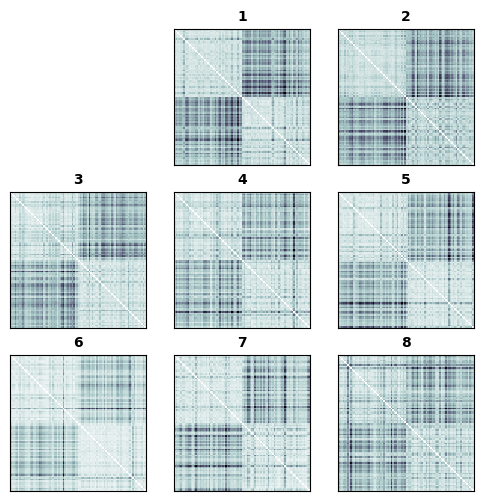

In [15]:
fmri_rdms = rsa.rdm.concat(fmri_rdms_list)
fig = rsa.vis.rdm_plot.show_rdm(ffa_rdms, rdm_descriptor='subject')[0]

### Visualizing AlexNet RDMs

Let's look at RDMs for different layers of AlexNet.

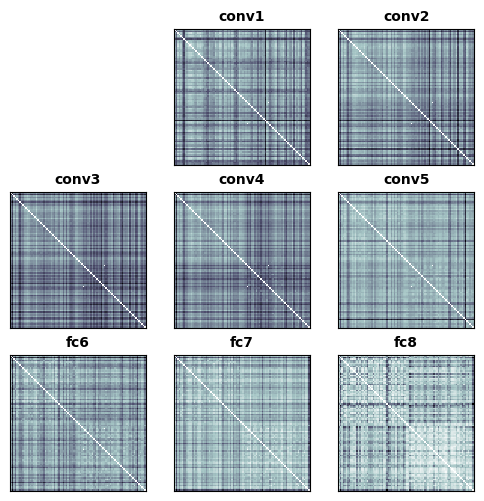

In [16]:
alexnet_rdms = rsa.rdm.concat(alexnet_rdms_dict.values())
fig = rsa.vis.rdm_plot.show_rdm(alexnet_rdms, rdm_descriptor='layer')[0]

We see a similar pattern emerge clustering face and non-face images in fully connected "fc6", "fc7", "fc8" layers.

AlexNet seems to "care" about faces too, at least to some extent.

In [17]:
intplot.show_rdm_plotly(alexnet_rdms, rdm_descriptor='layer')

# 4. RSA: model comparison and statistical inference

In the second step of RSA, each model is evaluated by the accuracy of its prediction of the data RDM. To this end, we will use the RDMs we computed for each model representation.

Each model’s prediction of the data RDM is evaluated using an RDM comparator, in this case we will use the correlation coefficient. 

First, let's look at the performance of different Alexnet layers against all the subjects

In [18]:
# get the Model objects to use the rsa toolbox for model comparisons
models = []
for layer, rdm in alexnet_rdms_dict.items():
    models.append(rsa.model.ModelFixed(rdm=rdm, name=layer))

In [19]:
roi = 'FFA'
human_rdms = fmri_rdms.subset('roi', roi)
models_to_compare = models

method = 'corr'
result =  rsa.inference.evaluate.eval_fixed(models_to_compare, human_rdms, method=method) # get the performance of the models compared to the fMRI data of the first 3 subjects for the FFA ROI

fig = intplot.plot_bars_and_scatter_with_table(result, models_to_compare, method, table = False)
fig.update_layout(title=dict(text = f"Performance of AlexNet layers on stimuli <br> in {roi} ROI for original set of subjects",
                              x=0.5, y=0.95,
                              font=dict(size=15)))
intplot.add_noise_ceiling_to_plot(fig, result.noise_ceiling)
#fig.update_layout(width=600)
fig.show()


In the plot, each data point represents the representational dissimilarity matrix (RDM) for an individual subject. The observed variability reflects the extent to which our models accurately predict neural activity patterns across different individuals.

Our goal is to determine how these results might generalize to a new cohort of subjects and new sets of stimuli. Since we cannot practically rerun the experiment countless times with fresh subjects and stimuli, we turn to computational simulations.

To achieve this, we will employ bootstrap resampling—a statistical technique that involves resampling our existing dataset with replacement to generate multiple simulated samples. This approach allows us to mimic the process of conducting the experiment anew with different subjects.

First let's focus on generalization to new subjects. By bootstrapping the subject dataset, for each simulated sample, we can compute the predictive accuracy of our models on the subjects' RDMs. After running many simulations, we will accumulate a distribution of accuracy estimates. This distribution will enable us to perform statistical inferences about our models’ generalizability to new subjects. (Later, we will address the problem of generalizing to new stimuli as well.)

Let's simulate a 'new' sample of subjects by bootstrap resampling, using the RSA toolbox. 

In [20]:
boot_rdms, idx = rsa.inference.bootstrap_sample_rdm(human_rdms, rdm_descriptor='subject')

now we plot the rdms of the bootstrapped sample

each rdm is a subject (note that some subjects might be repeated and some might be missing in the bootstrapped sample)

In [21]:
fig1 = intplot.show_rdm_plotly(fmri_rdms.subset('roi', 'FFA'), rdm_descriptor='subject')
fig1.update_layout(title=dict(text = f"Original sample of subjects",
                             x=0.5, y=0.95,
                             font=dict(size=20)))
fig2 = intplot.show_rdm_plotly(boot_rdms.subset('roi', 'FFA'), rdm_descriptor='subject')
fig2.update_layout(title=dict(text = f"Bootstrapped sample of subjects",
                             x=0.5, y=0.95,
                             font=dict(size=20)))
fig1.show()
fig2.show()

Let's see the model performance on different bootstrap resampled subject sets

In [22]:
boot_rdms, idx = rsa.inference.bootstrap_sample_rdm(human_rdms, rdm_descriptor='subject')
eval_result = rsa.inference.evaluate.eval_fixed(models_to_compare, boot_rdms, method=method) 
fig = intplot.plot_bars_and_scatter_with_table(eval_result, models, method, color='blue', table = False)
fig

If you run the cell above again, you will see the model performance for a new bootstrap sample of subjects. Explore how the results change for each simulated new cohort. 

In the third and final step of RSA, we conduct inferential comparisons between models based on their accuracy in predicting the representational dissimilarity matrices (RDMs).

We leverage the variability in the performance estimates observed in the bootstrapped samples to conduct statistical tests. These tests are designed to determine whether the differences in RDM prediction accuracy between models are statistically significant.

In [23]:
import translate_significance_code as tsc
tsc.plot_model_comparison_trans(result)

Details of the figure above:
model comparisons: two-tailed t-test, FDR q < 0.01. Error bars indicate the standard error of the mean. One-sided comparisons of each model performance against 0 and against the lower-bound estimate of the noise ceiling are Bonferroni-corrected for the number of models.

### Generalization to new images

We have applied a method that enables us to infer how well the models might perform when predicting neural activity patterns for a new cohort of subjects. However, this approach has not yet considered the variability that could arise from introducing a new set of stimuli to the participants.

To extend our inferences to the generalizability of the models with respect to new stimuli, we must replicate the bootstrapping procedure, focusing this time on the stimuli rather than the subjects. 

To do this, we will first maintain the original cohort of subjects and apply bootstrapping to resample the stimulus set.

In [24]:
# get the rdms for a bootstrap sample of the images
im_boot_rdms, pattern_idx = rsa.inference.bootstrap_sample_pattern(human_rdms, pattern_descriptor='index')


# plot RDMs 
fig = intplot.show_rdm_plotly(im_boot_rdms.subset('roi', 'FFA'), rdm_descriptor='subject')
fig

As before, rerunning the cell above will show you the RDMs for a new set of bootstrap resampled stimuli each time.

Let's see the inferential model comparisons based on 1000 bootstraps of the image set.

In [25]:
result = rsa.inference.eval_bootstrap_pattern(models, human_rdms, theta=None, method='corr', N=1000,
                           pattern_descriptor='index', rdm_descriptor='index',
                           boot_noise_ceil=True)

tsc.plot_model_comparison_trans(result)

100%|██████████| 1000/1000 [00:09<00:00, 105.00it/s]


# 5. Model Comparison Using Two-factor Bootstrap

For generalization across both the subject and stimulus populations, we can use a two-factor bootstrap method. For an in-depth discussion of this technique, refer to Schütt et al., 2023.

We can use the RSA toolbox to implement bootstrap resampling of subjects and stimuli simultaneously. It it important to note that a naive 2-factor bootstrap approach triple-counts the variance contributed by the measurement noise. For further understanding of this issue, see the explanation provided by Schütt et al. Fortunately, the RSA toolbox has an implementation that corrects for this potential overestimation.

Let's evaluate the performance of the models with simultaneous bootstrap resampling of the subjects and stimuli.

In [26]:
eval_result = rsa.inference.eval_dual_bootstrap(models, fmri_rdms.subset('roi', 'FFA'), method='corr')
print(eval_result)

100%|██████████| 1000/1000 [00:29<00:00, 33.70it/s]

Results for running dual_bootstrap evaluation for corr on 8 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 |  0.035 ± 0.040 |        0.210  |       < 0.001  |
conv2 |  0.090 ± 0.050 |        0.057  |       < 0.001  |
conv3 |  0.089 ± 0.050 |        0.059  |       < 0.001  |
conv4 |  0.127 ± 0.056 |        0.030  |       < 0.001  |
conv5 |  0.104 ± 0.058 |        0.057  |       < 0.001  |
fc6   |  0.118 ± 0.050 |        0.026  |       < 0.001  |
fc7   |  0.064 ± 0.035 |        0.055  |       < 0.001  |
fc8   |  0.153 ± 0.049 |        0.008  |       < 0.001  |

p-values are based on uncorrected t-tests


In [27]:
tsc.plot_model_comparison_trans(eval_result)

# Further reading

### Representational Similarity Analysis (RSA)

Kriegeskorte, N., Mur, M., & Bandettini, P. A. (2008). Representational similarity analysis-connecting the branches of systems neuroscience. Frontiers in systems neuroscience, 2, 249.
[link](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full)


### Two-factor bootstrap

Heiko H Schütt, Alexander D Kipnis, Jörn Diedrichsen, Nikolaus Kriegeskorte (2023) Statistical inference on representational geometries. eLife 12:e82566.
[link](https://elifesciences.org/articles/82566)

### RSA Toolbox
RSA Toolbox documentation [link](https://rsatoolbox.readthedocs.io/en/stable/index.html)

### Natural Scenes Dataset and Algonauts

Allen, E.J., St-Yves, G., Wu, Y., Breedlove, J.L., Prince, J.S., Dowdle, L.T., Nau, M., Caron, B., Pestilli, F., Charest, I., Hutchinson, J.B., Naselaris, T.*, Kay, K.* A massive 7T fMRI dataset to bridge cognitive neuroscience and artificial intelligence. Nature Neuroscience (2021).
[link](https://www.nature.com/articles/s41593-021-00962-x)

Gifford AT, Lahner B, Saba-Sadiya S, Vilas MG, Lascelles A, Oliva A, Kay K, Roig G, Cichy RM. 2023. The Algonauts Project 2023 Challenge: How the Human Brain Makes Sense of Natural Scenes. arXiv preprint, arXiv:2301.03198.
[link](https://doi.org/10.48550/arXiv.2301.03198)

### AlexNet

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25.
[link](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)